/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Average error:  3.288362539809431
Average error:  3.321745025448622
Average error:  3.3359615920326497
Average error:  3.314887674761695
Average error:  3.3544583286059195
Average error:  3.3209936067766064
Average error:  3.3558040298842906
Average error:  3.3328220640980275
Average error:  3.3276784094284095
Average error:  3.288725562669055
Average error:  3.3116850024548485
Average error:  3.3633070476342697
Average error:  3.308755103039674
Average error:  3.2925771836577935
Average error:  3.289253938847954
Average error:  3.3584331912793894
Average error:  3.351704007094167
Average error:  3.3257641024480407
Average error:  3.349185698685294
Average error:  3.2988038187195174
Average error:  3.3120226335930716
Average error:  3.318117406708665
Average error:  3.3234067519834505
Average error:  3.3125796060255013
Average error:  3.334975607413044
Average error:  3.320533019666017
Average error:  3.3257796747783077
Average error:  3.329917952800122
Average error:  3.33883180146345

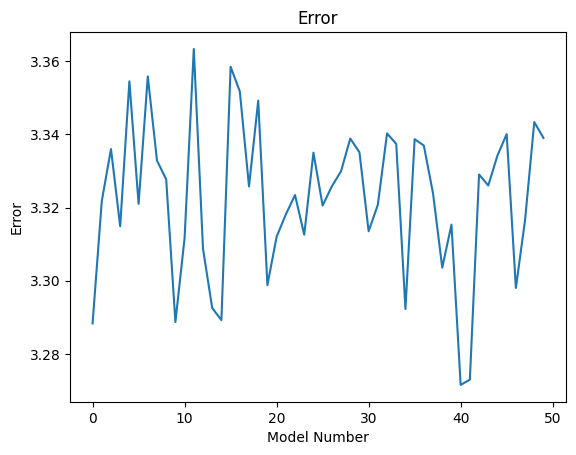

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import sklearn.model_selection
import xgboost as xgb
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

errors = []

for i in range(50):

    error = 0 

    for i in range(10):


        data = pd.read_csv("/kaggle/input/f1-weather/mlp_data_final.csv")
        data.dropna(inplace=True)
        le = LabelEncoder()
        data["Event"] = le.fit_transform(data['Event'])
        

        X = (data.loc[:, data.columns != 'NextLapTime']).to_numpy()
        Y = (data.loc[:, data.columns == 'NextLapTime']).to_numpy()

        X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y.ravel(), test_size=0.2, shuffle=True,)
        X_train = sklearn.preprocessing.normalize(X_train)
        X_test = sklearn.preprocessing.normalize(X_test)
        model = xgb.XGBRegressor(objective ='reg:squarederror')

        # Train the model
        model.fit(X_train, Y_train)

        # Predicting the Test set results
        y_pred = model.predict(X_test)

        # Evaluate the model
        error += (mean_squared_error(Y_test, y_pred))**0.5

    print("Average error: ", error/10)
    errors.append(error/10)


plt.title("Error")
plt.xlabel("Model Number")
plt.ylabel("Error")
plt.plot(errors)
plt.
plt.show()

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing


device = 'cuda'

# Load your dataset

data = pd.read_csv("/kaggle/input/f1-weather/mlp_data_final.csv")
data.dropna(inplace=True)
le = LabelEncoder()
data["Event"] = le.fit_transform(data['Event'])
        
X = (data.loc[:, data.columns != 'NextLapTime']).to_numpy()
y = (data.loc[:, data.columns == 'NextLapTime']).to_numpy()


# Splitting the dataset into the Training, Validation, and Test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train = sklearn.preprocessing.normalize(X_train)
X_val = sklearn.preprocessing.normalize(X_val)
X_test = sklearn.preprocessing.normalize(X_test)


# Define a parameter grid to search
param_grid = {
    'max_depth': [6, 12, 24],
    'learning_rate': [0.01, 0.1, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'tree_method': ['hist']  # Add this for GPU usage
}

# Initialize the XGBoost Regressor with GPU support
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', tree_method='hist', device='cuda')

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:24:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 300, 'subsample': 0.9, 'tree_method': 'hist'}


In [2]:
# Train model with best parameters on the combined training and validation sets
best_params = grid_search.best_params_
best_params['tree_method'] = 'hist'  # Ensure GPU usage in the final model
model = xgb.XGBRegressor(**best_params, objective ='reg:squarederror', device='cuda')
model.fit(pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)]), list(y_train)+list(y_val))

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE on Test Set: {rmse}")

Final RMSE on Test Set: 2.716977285752597
